In [1]:
import pandas as pd
import json
import requests
import geopandas as gpd
from shapely.geometry import box, Polygon
from tqdm import tqdm_notebook

In [2]:
dates = requests.get('https://openaltimetry.org/data/icesat2/getTrackDate').json()
tracks = gpd.read_file(r"./trackDATA/icesat2_tracks.shp")

crs = {'init': 'epsg:4326'}
extents = [5.35,53.4,6.2,53.5]
polygon_geom = Polygon(zip([extents[0],extents[2],extents[2],extents[0]], [extents[1],extents[1],extents[3],extents[3]]))
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       

# Clip data
tracks_clip = gpd.clip(tracks, polygon)
trackids = tracks_clip.TrackId.values

import folium
m = folium.Map([53.3,6.1], zoom_start=10, tiles='cartodbpositron')
folium.GeoJson(polygon).add_to(m)
folium.GeoJson(tracks_clip).add_to(m)
folium.LatLngPopup().add_to(m)
m

C:\Users\morenoro\AppData\Local\Continuum\anaconda3\envs\delta\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\morenoro\AppData\Local\Continuum\anaconda3\envs\delta\lib\site-packages\ipykernel_launcher.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  # Remove the CWD from sys.path while we load stuff.


In [26]:
for trackid in trackids:
    Datadic = {}
    dateslist = dates['track_{}'.format(trackid)].split(',')
    
    for date in dateslist:
        print(trackid, date)
        # Paste the OpenAltimetry API URL for Photon here: 
        OA_API_URL = 'https://openaltimetry.org/data/api/icesat2/atl03?&minx={}&miny={}&maxx={}&maxy={}&date={}&trackId={}&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l' \
                    .format(extents[0],extents[1],extents[2],extents[3],date,trackid)

        # Select the list of confidence to display: 'Noise', 'Buffer', 'Low', 'Medium', 'High'
        OA_PHOTON_CONFIDENCE = ['Medium', 'High']
        df_beams = []

        # This function will request the 6 beams data using OpenAltimetry's API
        def getPhotonData(OA_API_URLi):
            series = []
            b_url = OA_API_URLi + '&client=jupyter'
            print('Requesting data from OA')
            r = requests.get(b_url)
            data = r.json()
            return data

        photon_cloud = getPhotonData(OA_API_URL)
        for beam in photon_cloud:
            print('Reading data for beam: ' + beam['beam_name'])
            for photons in beam['series']:
                if any(word in photons['name'] for word in OA_PHOTON_CONFIDENCE):
                    series = []
                    for p in photons['data']:
                        series.append({'lat': p[0],'lon': p[1],'h': p[2]})
                    if (len(series) > 0):
                        print('Available')
                        df = pd.DataFrame.from_dict(series)
                        df.name = beam['beam_name'] + ' ' + photons['name']
                        df_beams.append(df)
                        
        Datadic['ID_{}_{}'.format(trackid, date)] = df_beams

252 2018-10-15
Requesting data from OA
Reading data for beam: gt3r
Reading data for beam: gt3l
Reading data for beam: gt2r
Reading data for beam: gt2l
Reading data for beam: gt1r
Reading data for beam: gt1l
252 2019-01-13
Requesting data from OA
Reading data for beam: gt3r
Available
Available
Reading data for beam: gt3l
Available
Available
Reading data for beam: gt2r
Available
Available
Reading data for beam: gt2l
Available
Available
Reading data for beam: gt1r
Available
Available
Reading data for beam: gt1l
Available
Available
252 2019-01-14
Requesting data from OA
Reading data for beam: gt3r
Reading data for beam: gt3l
Reading data for beam: gt2r
Reading data for beam: gt2l
Reading data for beam: gt1r
Reading data for beam: gt1l
252 2019-04-14
Requesting data from OA
Reading data for beam: gt3r
Available
Available
Reading data for beam: gt3l
Available
Available
Reading data for beam: gt2r
Available
Available
Reading data for beam: gt2l
Available
Available
Reading data for beam: gt1r


<IPython.core.display.Javascript object>


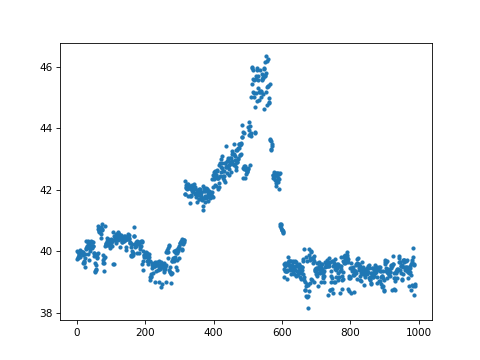

<IPython.core.display.Javascript object>


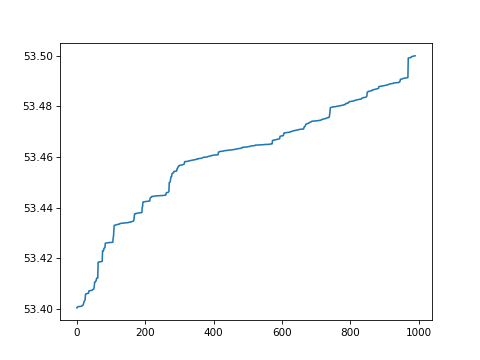

In [46]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
plt.figure()
plt.plot(Datadic['ID_1357_2019-03-27'][0]['h'], '.')
plt.figure()
plt.plot(Datadic['ID_1357_2019-03-27'][0]['lat'])
